In [21]:
import os
import sys
import csv
import pandas as pd
import numpy as np

import os.path
from os import path

import openslide
from skimage.color import rgb2hsv
import PIL
from PIL import Image

import cv2
import glob
import h5py
import os
import pathlib
import tables

import torch
from skimage import io, transform
from sklearn import metrics
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from matplotlib import pyplot

import torch
import timm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.functional import kl_div, softmax, log_softmax

In [2]:
hdf5_path = '/home/irene/Downloads/luadlusc.hdf5'
file = h5py.File(hdf5_path, "r")
file.keys()

<KeysViewHDF5 ['test_img', 'test_label', 'train_img', 'train_label', 'val_img', 'val_label']>

In [3]:
rgb_mean,rgb_std = (0.485, 0.456, 0.406),(0.229, 0.224, 0.225)

In [4]:
class HDF5Dataset(Dataset):


    def __init__(self, h5_path, set_name, transform = None):
        self.h5_path = h5_path
        self.dataset = None
        self.transform = transform
        self.file_path  = h5_path
        self.set = set_name
        
        str_name = self.set + "_img"
        
        file = h5py.File(h5_path, "r")
        self.dataset_len = len(file[str_name])
        
        self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(rgb_mean,rgb_std)
            ])
        
    def __getitem__(self, index): #to enable indexing
        
        if self.dataset is None:
            self.imgs = h5py.File(self.file_path, 'r')[self.set + "_img"]
            self.labels = h5py.File(self.file_path, 'r')[self.set + "_label"]
            
            cur_img = self.imgs[index]
            PIL_image = Image.fromarray(np.uint8(cur_img)).convert('RGB')#3 channels don't need alpha channel network input
            image = self.transform(PIL_image)
            label = self.labels[index].astype('float32')
            
            
        return (image,label)

    def __len__(self):
        return self.dataset_len

In [5]:
from torch.utils.data import Dataset,DataLoader

train_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="train"), batch_size=8,shuffle=True,drop_last=False)
val_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="val"), batch_size=8,shuffle=True,drop_last=False)
test_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="test"), batch_size=8,shuffle=True,drop_last=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

out_dim = 2

model = timm.create_model("inception_v3", pretrained=True)
model.fc = nn.Linear(model.fc.in_features, out_dim)

model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,weight_decay = 1e-4,momentum = 0.9)
criterion = nn.CrossEntropyLoss()



def train_valid_model (net,loaders,max_epochs = 20):
    best_acc = 0.0 
    for epoch in range (max_epochs):
        for phase in ['train','val']:
            iterator = iter(loaders[phase])
            total_step = len(loaders[phase])
            print('Phase {}'.format(phase))
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            running_loss = 0.0
            running_correct = 0
            
            predictions_all = []
            label_all = []
            probs_all = []
            for step in range(total_step-1): #iterate each batch
                images,labels = next(iterator) # CUDA computation
                images = images.to(device)
                labels = labels.to(device)
                labels = labels.long()
                optimizer.zero_grad()
                
                output = net(images)
                loss = criterion(output,labels)
                
                probs = torch.nn.functional.softmax(output, dim=1) # probabilities
                
                running_loss +=loss.item()
                _, preds = torch.max(output.data,1)
                
                running_correct += (preds == labels).sum().item()
                
                if len(predictions_all) == 0:
                    predictions_all = preds.detach().cpu().numpy()
                    label_all = labels.detach().cpu().numpy()
                    probs_all = probs.detach().cpu().numpy()
                else:
                    predictions_all = np.vstack((predictions_all, preds.detach().cpu().numpy()))
                    probs_all = np.vstack((probs_all, probs.detach().cpu().numpy()))
                    label_all = np.vstack((label_all, labels.detach().cpu().numpy()))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
                    
            phase_loss = running_loss / len(loaders[phase])
            phase_acc = running_correct/len(label_all.flatten())
            if phase == 'val':
                y_true = label_all.flatten()
                y_pred = predictions_all.flatten()
                print("validating...")
                print(len(y_true))
                print(len(y_pred))
                print(metrics.classification_report(y_true, y_pred, digits=3))
            if phase == 'val' and phase_acc > best_acc:
                
                best_acc = phase_acc
                import copy 
                
                best_model_state_dict = copy.deepcopy(net.state_dict())
                torch.save(best_model_state_dict,'inceptionv3best_model.pth')
                
            print('PHASE {} Loss: {:.4f} Acc: {:.4f}'.format(phase, phase_loss, phase_acc))
    net.load_state_dict(best_model_state_dict)
    
    return net 
            
       
print(device)  

cuda


In [14]:
def test_best_model (net, test_loader, a_device = None):
    iterator = iter(test_loader)
    total_step = len(test_loader)
    
    print(total_step)
    net.eval()
    
    with torch.no_grad():
        running_loss = 0
        running_corrects = 0
        
        total_0,total_1 = 0,0
        hit_0 = 0
        hit_1 = 0
        label_all = []
        probs_all = []
        predictions_all = []
        for step in range(total_step-1):
            images,labels = next(iterator)
            images.to(a_device)
            labels.to(a_device)
            total_0 += labels.tolist().count(0)
            total_1 += labels.tolist().count(1)
            print(labels.shape)
            images = images.to(a_device)
            labels = labels.to(device=a_device, dtype=torch.int64)
            labels = labels.long()
            
            output = net(images)
            loss = criterion(output,labels)
            
            probs = torch.nn.functional.softmax(output, dim=1)

            running_loss +=loss.item()
            _, preds = torch.max(output.data,1)
            
            equals = preds == labels.view(*preds.shape)
            if(len(label_all) ==0):
                predictions_all = preds.detach().cpu().numpy()
                label_all = labels.detach().cpu().numpy()
                probs_all = probs.detach().cpu().numpy()
            else:
                predictions_all = np.vstack((predictions_all, preds.detach().cpu().numpy()))
                label_all = np.vstack((label_all, labels.detach().cpu().numpy()))
                probs_all = np.vstack((probs_all, probs.detach().cpu().numpy()))

            all_hits = equals.view(equals.shape[0]).tolist() 
            all_corrects = labels[all_hits]
            
            hit_0 += all_corrects.tolist().count(0)
            hit_1 += all_corrects.tolist().count(1)
 
        
            running_corrects += (preds == labels).sum().item()
        print(len(label_all.flatten()))
        label_all = label_all.flatten()
        predictions_all = predictions_all.flatten()
        phase_loss = running_loss / len(test_loader)
        phase_acc = running_corrects/len(label_all.flatten())
        print('Test Loss: {:.4f} Acc: {:.4f}'.format(phase_loss, phase_acc))
        
        print(hit_0, ' / ',total_0)
        print(hit_1, ' / ',total_1)
                
            
    return label_all, probs_all, predictions_all #add this later
                
        #y_test --> label, y_score --> probs all 

In [8]:
epochs = 10
loaders = dict({'train': train_loader, 'val': val_loader})
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------")
    bestmodel = train_valid_model (model,loaders)
    

Epoch 1
-----------------------
Phase train
PHASE train Loss: 0.4878 Acc: 0.7591
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.903     0.764     0.828      4529
           1      0.825     0.931     0.875      5399

    accuracy                          0.855      9928
   macro avg      0.864     0.848     0.851      9928
weighted avg      0.860     0.855     0.853      9928

PHASE val Loss: 0.3121 Acc: 0.8550
Phase train
PHASE train Loss: 0.3371 Acc: 0.8520
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.908     0.933     0.920      4529
           1      0.942     0.921     0.931      5399

    accuracy                          0.926      9928
   macro avg      0.925     0.927     0.926      9928
weighted avg      0.927     0.926     0.926      9928

PHASE val Loss: 0.1937 Acc: 0.9263
Phase train
PHASE train Loss: 0.2569 Acc: 0.8957
Phase val
validating...
9928


PHASE train Loss: 0.0247 Acc: 0.9915
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.992     0.968     0.980      4529
           1      0.974     0.993     0.983      5399

    accuracy                          0.982      9928
   macro avg      0.983     0.981     0.982      9928
weighted avg      0.982     0.982     0.982      9928

PHASE val Loss: 0.0581 Acc: 0.9819
Epoch 2
-----------------------
Phase train
PHASE train Loss: 0.0406 Acc: 0.9855
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.981     0.985     0.983      4528
           1      0.987     0.984     0.986      5400

    accuracy                          0.984      9928
   macro avg      0.984     0.985     0.984      9928
weighted avg      0.984     0.984     0.984      9928

PHASE val Loss: 0.0486 Acc: 0.9845
Phase train
PHASE train Loss: 0.0416 Acc: 0.9860
Phase val
validating...
9928
9928
       

PHASE val Loss: 0.0372 Acc: 0.9900
Phase train
PHASE train Loss: 0.0187 Acc: 0.9930
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.993     0.984     0.988      4528
           1      0.987     0.994     0.990      5400

    accuracy                          0.989      9928
   macro avg      0.990     0.989     0.989      9928
weighted avg      0.989     0.989     0.989      9928

PHASE val Loss: 0.0298 Acc: 0.9894
Phase train
PHASE train Loss: 0.0136 Acc: 0.9953
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.978     0.991     0.985      4529
           1      0.993     0.981     0.987      5399

    accuracy                          0.986      9928
   macro avg      0.985     0.986     0.986      9928
weighted avg      0.986     0.986     0.986      9928

PHASE val Loss: 0.0496 Acc: 0.9860
Epoch 3
-----------------------
Phase train
PHASE train Loss: 0.0147 Acc: 0

PHASE train Loss: 0.0128 Acc: 0.9959
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.986     0.986     0.986      4529
           1      0.988     0.988     0.988      5399

    accuracy                          0.987      9928
   macro avg      0.987     0.987     0.987      9928
weighted avg      0.987     0.987     0.987      9928

PHASE val Loss: 0.0480 Acc: 0.9870
Phase train
PHASE train Loss: 0.0101 Acc: 0.9966
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.982     0.992     0.987      4529
           1      0.993     0.984     0.989      5399

    accuracy                          0.988      9928
   macro avg      0.987     0.988     0.988      9928
weighted avg      0.988     0.988     0.988      9928

PHASE val Loss: 0.0718 Acc: 0.9879
Phase train
PHASE train Loss: 0.0098 Acc: 0.9969
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0109 Acc: 0.9965
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.990     0.983     0.987      4529
           1      0.986     0.992     0.989      5399

    accuracy                          0.988      9928
   macro avg      0.988     0.988     0.988      9928
weighted avg      0.988     0.988     0.988      9928

PHASE val Loss: 0.0493 Acc: 0.9879
Phase train
PHASE train Loss: 0.0070 Acc: 0.9977
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.990     0.989     0.990      4529
           1      0.991     0.991     0.991      5399

    accuracy                          0.990      9928
   macro avg      0.990     0.990     0.990      9928
weighted avg      0.990     0.990     0.990      9928

PHASE val Loss: 0.0448 Acc: 0.9904
Phase train
PHASE train Loss: 0.0069 Acc: 0.9978
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0102 Acc: 0.9967
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.988     0.991     0.989      4528
           1      0.992     0.990     0.991      5400

    accuracy                          0.990      9928
   macro avg      0.990     0.990     0.990      9928
weighted avg      0.990     0.990     0.990      9928

PHASE val Loss: 0.0368 Acc: 0.9902
Phase train
PHASE train Loss: 0.0125 Acc: 0.9953
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.980     0.994     0.987      4528
           1      0.995     0.983     0.989      5400

    accuracy                          0.988      9928
   macro avg      0.988     0.989     0.988      9928
weighted avg      0.988     0.988     0.988      9928

PHASE val Loss: 0.0458 Acc: 0.9883
Phase train
PHASE train Loss: 0.0082 Acc: 0.9973
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0080 Acc: 0.9974
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.985     0.987     0.986      4528
           1      0.989     0.988     0.988      5400

    accuracy                          0.987      9928
   macro avg      0.987     0.987     0.987      9928
weighted avg      0.987     0.987     0.987      9928

PHASE val Loss: 0.0666 Acc: 0.9873
Phase train
PHASE train Loss: 0.0099 Acc: 0.9966
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.991     0.985     0.988      4528
           1      0.987     0.992     0.990      5400

    accuracy                          0.989      9928
   macro avg      0.989     0.989     0.989      9928
weighted avg      0.989     0.989     0.989      9928

PHASE val Loss: 0.0458 Acc: 0.9889
Phase train
PHASE train Loss: 0.0074 Acc: 0.9975
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0074 Acc: 0.9975
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.979     0.993     0.986      4528
           1      0.994     0.982     0.988      5400

    accuracy                          0.987      9928
   macro avg      0.986     0.987     0.987      9928
weighted avg      0.987     0.987     0.987      9928

PHASE val Loss: 0.0473 Acc: 0.9869
Phase train
PHASE train Loss: 0.0080 Acc: 0.9973
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.991     0.989     0.990      4528
           1      0.991     0.993     0.992      5400

    accuracy                          0.991      9928
   macro avg      0.991     0.991     0.991      9928
weighted avg      0.991     0.991     0.991      9928

PHASE val Loss: 0.0333 Acc: 0.9911
Phase train
PHASE train Loss: 0.0073 Acc: 0.9973
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0058 Acc: 0.9981
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.996     0.976     0.986      4529
           1      0.980     0.996     0.988      5399

    accuracy                          0.987      9928
   macro avg      0.988     0.986     0.987      9928
weighted avg      0.987     0.987     0.987      9928

PHASE val Loss: 0.0444 Acc: 0.9871
Phase train
PHASE train Loss: 0.0048 Acc: 0.9983
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.989     0.993     0.991      4529
           1      0.994     0.991     0.992      5399

    accuracy                          0.992      9928
   macro avg      0.991     0.992     0.992      9928
weighted avg      0.992     0.992     0.992      9928

PHASE val Loss: 0.0361 Acc: 0.9916
Phase train
PHASE train Loss: 0.0095 Acc: 0.9967
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0045 Acc: 0.9986
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.987     0.992     0.990      4529
           1      0.994     0.989     0.991      5399

    accuracy                          0.991      9928
   macro avg      0.990     0.991     0.990      9928
weighted avg      0.991     0.991     0.991      9928

PHASE val Loss: 0.0336 Acc: 0.9905
Phase train
PHASE train Loss: 0.0065 Acc: 0.9979
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.991     0.989     0.990      4528
           1      0.990     0.993     0.992      5400

    accuracy                          0.991      9928
   macro avg      0.991     0.991     0.991      9928
weighted avg      0.991     0.991     0.991      9928

PHASE val Loss: 0.0369 Acc: 0.9908
Phase train
PHASE train Loss: 0.0044 Acc: 0.9985
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0050 Acc: 0.9982
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.989     0.992     0.990      4528
           1      0.993     0.990     0.992      5400

    accuracy                          0.991      9928
   macro avg      0.991     0.991     0.991      9928
weighted avg      0.991     0.991     0.991      9928

PHASE val Loss: 0.0306 Acc: 0.9910
Phase train
PHASE train Loss: 0.0071 Acc: 0.9973
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.974     0.992     0.983      4529
           1      0.993     0.978     0.985      5399

    accuracy                          0.984      9928
   macro avg      0.983     0.985     0.984      9928
weighted avg      0.984     0.984     0.984      9928

PHASE val Loss: 0.0617 Acc: 0.9841
Phase train
PHASE train Loss: 0.0059 Acc: 0.9981
Phase val
validating...
9928
9928
              precision    recall  f1-s

In [8]:
model_path = 'inceptionv3best_model.pth'

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

out_dim = 2

model = timm.create_model("inception_v3", pretrained=True)
model.fc = nn.Linear(model.fc.in_features, out_dim)

In [10]:
my_dict = torch.load(model_path)

In [11]:
model.load_state_dict(my_dict)

<All keys matched successfully>

In [12]:
model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,weight_decay = 1e-4,momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [15]:
y_test, y_prob, y_pred= test_best_model (model, test_loader, a_device = device)


1242
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
tor

torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Si

torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Si

In [17]:
fpr = dict()
tpr = dict()

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])

In [18]:
roc_auc = roc_auc_score(y_test, y_prob[:,1])
print('AUC: %.3f' % roc_auc)

AUC: 1.000


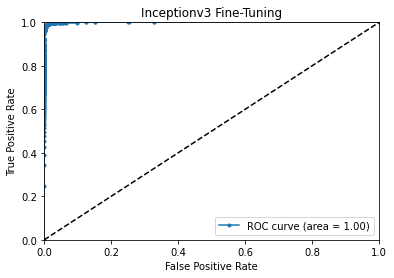

In [19]:
# ROC Curves and AUC
plt.plot(fpr,tpr ,marker='.', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Inceptionv3 Fine-Tuning')
plt.legend(loc="lower right")
plt.savefig('Inceptionv3_Fine_Tuning.png')

In [22]:
accuracy = accuracy_score(y_test,y_pred,normalize = True)
print(accuracy)

0.9902296535052377


In [23]:
f1 = f1_score(y_test, y_pred)
print(f1)

0.9910541363091396


In [48]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])
auc = auc(recall, precision)

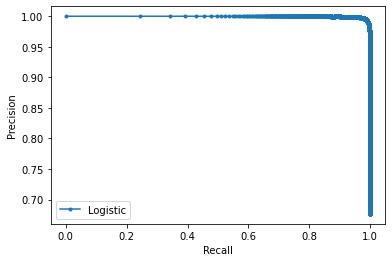

In [49]:
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

In [ ]:
#svm 
#representation learning --> more practical, more adaptive to the dataset, baby in whatever scenario or world, very general, only need to know the basics and how to survive. 
#fintuning --> more intuitive. Fine tuning --> for this dataset, very familiar. Can't include everything, can't generalize everything